In [23]:
import numpy as np
X1 = np.random.multivariate_normal([0,0], 1e-3*np.diag(np.ones(2)),33)
X2 = np.random.multivariate_normal([0.2,0.8], 1e-3*np.diag(np.ones(2)),33)
X3 = np.random.multivariate_normal([0.8,0.5], 1e-3*np.diag(np.ones(2)),33)
X = np.concatenate([X1,np.concatenate([X2,X3])])
np.random.shuffle(X)

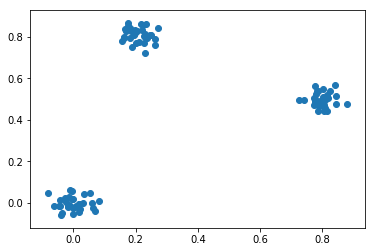

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0],X[:,1])

In [77]:
from cvxpy import *
from numba import jit
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
class EMtau(object):
    # A EM-like algorithm that penalizes the columns of the posterior matrix tau
    # resulting to a "sparse" estimation of the weights i.e. a estimation of the number of clusters
    
    def __init__(self, kmax=2, n_iter=10):
        self.kmax = kmax
        self.n_iter = n_iter
        self.fista_iter = 200
        self.lambd = 1
        self.lambda_pen = 10
    
    def tau_gen(self, X):
        densities = np.array([multivariate_normal(self.centers[k], self.covars[k]).pdf(X) for k in range(self.kmax)]).T*self.pi
        s = densities.sum(axis=1)
        return (densities.T/(densities.sum(axis=1))).T
    
    def covar_gen(self, X, i):
        a = (X-self.centers[i])*(np.sqrt(self.tau[:,i]).reshape(-1,1))
        return a.T.dot(a)/(self.N*self.pi[i])
    @jit
    def f_gradient(self, xi, X):
        #give gradient of f on xi
        temp = np.zeros([self.kmax, self.N])
        for i in range(self.kmax):
            temp[i] = -np.log(multivariate_normal(self.centers[i], self.covars[i]).pdf(X)) - np.log(self.pi[i]/xi[:,i]) +1 + self.lambda_pen*xi[:,i]/(np.linalg.norm(xi, axis=0)[i])
        return temp.T

    @jit()
    def simplex_proj_numba(self, y):
        dim = len(y)
        u = np.flip(np.sort(y),0)
        maxi = 0
        lambd = 0
        for i in range(dim):
            crit = u[i]+1./(i+1)*(1-u[:i+1].sum())
            if crit > 0 and i > maxi:
                maxi = i
        s = u[:maxi+1].sum()
        lambd = 1./(maxi+1)*(1.-s)
        res = np.zeros(dim)
        for j in range(dim):
            res[j] = max(y[j]+lambd, 0)
        return res
    @jit
    def proj_simplex_row_matrix(self, Y):
        res = np.zeros(Y.shape)
        for i in range(Y.shape[0]):
            res[i] = self.simplex_proj_numba(Y[i])
        return res
    #@jit
    def expectation(self, X):
        # Estimation of tau with penalization on columns
        t_current = 1
        xi = np.copy(self.tau)
        tau_current = np.copy(xi)
        tau_next = np.ones([self.N, self.kmax])
        i=0
        # The thresholds given are purely experimental
        while  i < self.fista_iter:
            tau_current = np.copy(tau_next)         
            f_grad = self.f_gradient(xi, X)
            xi_next = xi-self.lambd*f_grad
            xi_next = np.nan_to_num(xi_next)
            tau_next = self.proj_simplex_row_matrix(xi_next)         
            t_next = (1+np.sqrt(1+4*t_current*2))/2
            xi = tau_next + (t_current - 1)/t_next*(tau_next - tau_current)
            # We set the negative values to 1e-20 to avoid errors with log in the gradient
            #xi[xi <= 0] = 1e-20
            t_current = t_next
            #print np.linalg.norm(tau_next,axis=1)
            i+=1
        self.tau = tau_next
    
    def maximization(self, X):
        self.pi = self.tau.sum(axis=0)/self.N
        self.centers = np.array([(X*(self.tau[:,i].reshape(-1,1))).sum(axis=0)/(self.N*self.pi[i]) for i in range(self.kmax)])
        self.covars = np.array([self.covar_gen(X, i) for i in range(self.kmax)])
    
    def fit(self, X):
        #init
        self.N = X.shape[0]
        kmeans = KMeans(self.kmax)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        self.pi = np.array([1.0*len(kmeans.labels_[kmeans.labels_==i])/self.N for i in range(self.kmax)])
        self.covars = np.array([1e-20*np.diag(np.ones(X.shape[1]))*np.cov((X[kmeans.labels_==i]- kmeans.cluster_centers_[i]).T) for i in range(self.kmax)])
        self.tau = self.tau_gen(X)
        
        #algorithm starts
        for i in range(self.n_iter):
            print "iter: ", i
            #self.tau[self.tau<=0] = 1e-20
            self.expectation(X)
            self.maximization(X)
        return self.pi, self.centers, self.covars
    

In [78]:
emtau = EMtau(kmax=5, n_iter=5)

In [79]:
emtau.fit(X)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide


iter:  0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in divide


iter:  1


ValueError: array must not contain infs or NaNs

In [ ]:
emtau.tau

In [18]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(5)

In [19]:
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [20]:
gmm.weights_

array([ 0.09076937,  0.1276379 ,  0.33333333,  0.24256396,  0.20569543])

In [50]:
gmm.means_

array([[ 0.00871185, -0.00181355],
       [ 0.19765643,  0.75945015],
       [ 0.84238601,  0.57172857],
       [ 0.761032  ,  0.44362419],
       [ 0.18991157,  0.85071262]])

In [10]:
tau = [[Variable() for _ in range(10) ] for _ in range(20)]
constraints = [sum_entries(bmat(ligne_n)) == 1 for ligne_n in tau ]

In [11]:
sum_entries(bmat(tau[0]))

Expression(AFFINE, UNKNOWN, (1, 1))

In [13]:
bmat(tau)

Expression(AFFINE, UNKNOWN, (20, 10))

In [51]:
print installed_solvers()


['CVXOPT', 'MOSEK', 'ECOS_BB', 'SCS', 'ECOS', 'LS']


In [142]:
    
    def expectation(self, X):
        # Estimation of tau with penalization on columns
        # We use CVXPY, a more efficient implementation would be to solve directly the optimization problem
        # with the appropriate procedure
        t_current = 1
        xi = super(EMtau, self).tau_gen(X)
        tau_current = np.copy(xi)
        tau_next = np.ones([self.N, self.kmax])
        i=0
        # The thresholds given are purely experimental
        while np.linalg.norm(tau_current-tau_next) > 1e-5 and i < self.fista_iter:
            tau_current = np.copy(tau_next)
            #tau = [[Variable() for _ in range(self.kmax) ] for _ in range(self.N)]
            #constraints = [
                #sum_entries(bmat(ligne_n)) == 1 for ligne_n in tau 
                 #         ]+[
             #   item >=0 for sublist in tau for item in sublist 
                #        ]+[
               # item <=1 for sublist in tau for item in sublist 
             #   ]             
            f_grad = self.f_gradient(xi, X)
            #import pdb; pdb.set_trace()
            xi_next = xi-self.lambd*f_grad
            tau_next = self.proj_simplex_row_matrix(xi_next)
            #prob = Problem(Minimize(norm(bmat(tau) - xi_next,"fro" )**2), constraints)
            #prob.solve(solver="SCS")
            #tau_next_temp = np.array(bmat(tau).value)
            
            t_next = (1+np.sqrt(1+4*t_current*2))/2
            xi = tau_next + (t_current - 1)/t_next*(tau_next - tau_current)
            # We set the negative values to 1e-20 to avoid errors with log in the gradient
            xi[xi <= 0] = 1e-20
            t_current = t_next
            #print np.linalg.norm(tau_next,axis=1)
            i+=1
        print np.linalg.norm(tau_next, axis=1)
        return tau_next

In [145]:
1/(2*np.ones([10,2]))

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5]])

In [42]:
1e-20*np.diag(np.ones(X.shape[1]))

array([[  1.00000000e-20,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e-20]])